# GA Capstone: Topic Modelling on AMD reddit comments

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA modeling](#Prepare-reddit-comments-for-LDA-modeling)
- [Phrase modeling: Bigram and Trigram models](#Phrase-modeling:-Bigram-and-Trigram-models)
- [LDA Model Training](#LDA-Model-Training)
- [LDA Mallet Model](#LDA-Mallet-Model)
- Model creation
- Model Evaluation

# Import the libraries

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pprint import pprint
import os
from collections import Counter

# Bokeh package for TSNE
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook

import re
# NLTK Library
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.models import LdaMulticore, CoherenceModel, Phrases
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora

# pyLDAvis library
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

# Removes depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

# Load the dataset

In [4]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25511,motherboard say pcie 0 compatible,nvidia
25512,thanks understanding know course 3000s dvi por...,nvidia
25513,buy 1400 gpu,nvidia
25514,know ill wait 3070 3060,nvidia


In [5]:
amd_df = GPU_df[GPU_df['tag'] == 'amd']
amd_df

,Reddit comments,tag
4698,sound samsung 8nm cheap,amd
4699,ethic mongol invasion tech,amd
4700,nvidia software ai learning big selling point,amd
4701,excited amd guy compete going nvidia brand loy...,amd
4702,think nvidia actualy competing new console pri...,amd
...,...,...
19219,dude understand example confused said looked r...,amd
19220,know example thought looked,amd
19221,probably score higher english proficiency test...,amd
19222,prove know concept cost opportunity efficiency...,amd


# Prepare comments for modeling

In [6]:
# Creates the bag of words for each document
data = [token.split() for token in amd_df['Reddit comments'].tolist()]

In [7]:
# Prints the bag of words from the first 3 documents
print(data[:3])

[['sound', 'samsung', '8nm', 'cheap'], ['ethic', 'mongol', 'invasion', 'tech'], ['nvidia', 'software', 'ai', 'learning', 'big', 'selling', 'point']]


## Phrase modeling: Bigram and Trigram models

In [8]:
# Build the bigram and trigram models
bigram = Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram, this reduces memory, making the model smaller and faster
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_bigrams = make_bigrams(data)

# Form Trigrams
data_trigrams = make_trigrams(data)

In [10]:
# Create a dictionary to hold the different n-grams dataset
phrase_list = {'unigram': data, 'bigrams': data_bigrams, 'trigrams': data_trigrams}
# phrase_list

# LDA on AMD comments with all the ngrams

In [11]:
# Creating a function to create the LDA model and compute the coherence score
def lda_calculate_coherence_values(ngram_data, num_topics):
    """
    This function calculates the coherence score and the perplexity scores for each ngram and stores
    the model, corpus and the id2word in their respective dictionaries
    """
    model_dict = {}
    score_dict = {}
    for key, value in ngram_data.items():
        ngram_id2word = corpora.Dictionary(value)
        ngram_corpus = [ngram_id2word.doc2bow(text) for text in value]

        ngram_lda_model = LdaMulticore(corpus=ngram_corpus, 
                             id2word=ngram_id2word, 
                             num_topics=num_topics,
                             chunksize=100,
                             passes=20, 
                             random_state=42,
                            per_word_topics=True)


        # Compute Perplexity score
        ngram_perplexity = ngram_lda_model.log_perplexity(ngram_corpus)  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=ngram_lda_model, texts=value, dictionary=ngram_id2word, coherence='c_v')
        ngram_coherence_lda = coherence_model_lda.get_coherence()
        
        # Prints out the topics for each ngram
        print(f'*********Displaying {num_topics} topics for {key}******************')
        pprint(ngram_lda_model.print_topics())
        
        # Store the perplexity and coherence scores in score_dict
        score_dict[key] = []
        score_dict[key].append(ngram_perplexity)
        score_dict[key].append(ngram_coherence_lda)
        
        # Stores the ngram's model, corpus, id2word in model_dict
        model_dict[key] = []
        model_dict[key].append(ngram_lda_model)
        model_dict[key].append(ngram_corpus)
        model_dict[key].append(ngram_id2word)

    return score_dict, model_dict, num_topics

In [12]:
# Calculate using a dictionary
score_dict, model_dict, num_topics = lda_calculate_coherence_values(phrase_list, 5)

*********Displaying 5 topics for unigram******************
[(0,
  '0.016*"3090" + 0.015*"6900xt" + 0.013*"3080" + 0.012*"6800xt" + '
  '0.011*"power" + 0.009*"vram" + 0.009*"good" + 0.008*"gaming" + '
  '0.008*"people" + 0.007*"think"'),
 (1,
  '0.028*"game" + 0.028*"dl" + 0.018*"amd" + 0.016*"ray" + 0.015*"tracing" + '
  '0.012*"nvidia" + 0.009*"rt" + 0.009*"driver" + 0.008*"feature" + '
  '0.008*"support"'),
 (2,
  '0.030*"price" + 0.026*"6800" + 0.024*"3070" + 0.014*"amd" + 0.012*"xt" + '
  '0.009*"card" + 0.008*"buy" + 0.008*"end" + 0.008*"nvidia" + 0.008*"vram"'),
 (3,
  '0.037*"nvidia" + 0.033*"amd" + 0.020*"3080" + 0.014*"rtx" + 0.011*"3090" + '
  '0.010*"better" + 0.010*"card" + 0.007*"3070" + 0.007*"2080" + 0.007*"ti"'),
 (4,
  '0.016*"series" + 0.016*"cpu" + 0.015*"amd" + 0.012*"stock" + 0.011*"order" '
  '+ 0.011*"launch" + 0.009*"card" + 0.008*"rage" + 0.008*"mode" + '
  '0.007*"5000"')]
*********Displaying 5 topics for bigrams******************
[(0,
  '0.011*"4k" + 0.011*"

## Intrepreting the topics for unigram

Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () means the score

Topic 0 (4)
* Talks about Nvidia's 3080 and 3090 and AMD's 6800xt and the 6900xt pertaining to their vram and power supplied

Topic 1 (4)
* Talks about DLSS (Deep Learning Super Sampling) and ray tracing which are features in Nvidia's GPUs as well as the drivers.

Topic 2 (2)
* 6800xt and 3070 gpus with regards to their price and vram

Topic 3 (3)
* Different models of GPUs

Topic 4 (1)
* Related to stocks availability

**3 topics were intrepretable.**

## Interpreting the topics for the bigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (1)
* 4k resolution and the 6800xt

Topic 1 (3)
* Different models of GPUs with regards to price and vram

Topic 2 (4)
* Talks about DLSS (Deep Learning Super Sampling) and ray tracing which are features in Nvidia's GPUs

Topic 3 (2)
* Driver and prices

Topic 4 (3)
* Related to stocks availability 

**3 topics were intrepretable.**

## Interpreting the topics for the trigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (3)
* Related to stocks availability.

Topic 1 (1)
* Different resolutions, 1080p and 4k. Monitor and cpu.

Topic 2 (4)
* Talks about DLSS (Deep Learning Super Sampling) and ray tracing which are features in Nvidia's GPUs

Topic 3 (4)
* Talks about the PSU (Power supply unit) and the power efficiency

Topic 4 (3)
* Different models of GPUs

**4 topics were intrepretable.**

In [60]:
topics_interpretable = [3,3,4]

In [61]:
score_df = pd.DataFrame(score_dict).T
score_df.columns = ['Perplexity score', 'Coherence score']
score_df['no of topics intrepretable'] = topics_interpretable
score_df

,Perplexity score,Coherence score,no of topics intrepretable
unigram,-7.678092,0.529254,3
bigrams,-7.722717,0.585108,3
trigrams,-7.759911,0.590325,4


## Summary

Using Coherence score as the main metric and no of topic intrepretable as the secondary metric to select the best ngram, between unigrams and bigrams, I'll be choosing **trigram** as the it has the larger number of intrepretable topics compared to the other n_grams and it has the **highest coherence score**.

## Visualizing the topics-keywords

In [63]:
# Obtaining the lda trigram model, corpus and dictionary
lda_trigram_model, trigram_corpus, trigram_id2word = model_dict['trigrams']

In [64]:
# Visualize the topics for the trigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'amd_' + 'trigram_' +'ldavis_prepared_'+str(num_topics))
trigram_vis = pyLDAvis.gensim.prepare(lda_trigram_model, trigram_corpus, trigram_id2word)
# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(trigram_vis, os.getcwd()+ '\\visualization\\' + 'amd_' + 'trigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')
trigram_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.104844 -0.014330       1        1  30.245057
4     -0.113997  0.156625       2        1  28.064417
0      0.022771  0.089911       3        1  18.872868
1     -0.065309 -0.229572       4        1  13.204165
3      0.261379 -0.002633       5        1   9.613493, topic_info=       Term         Freq        Total Category  logprob  loglift
97     3070  1335.000000  1335.000000  Default  30.0000  30.0000
384      dl  1569.000000  1569.000000  Default  29.0000  29.0000
5479   6800  1262.000000  1262.000000  Default  28.0000  28.0000
98     3080  1417.000000  1417.000000  Default  27.0000  27.0000
27    price  1609.000000  1609.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
1882   shit    59.258991   210.575270   Topic5  -5.7239   1.0741
14      amd    89.631546  3110.355684   Topic5  -5.3101  -1.2048
112    said    69.725919   682.776014   Topic5  -5.5612   0.0604
164    look    67.557019   624.802281   Topic5  -5.5928   0.1175
74     need    60.243414   710.079718   Topic5  -5.7074  -0.1250

[374 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
415       1  0.863946        0
415       3  0.053229        0
415       4  0.081891        0
415       5  0.004095        0
2750      4  0.982580   1070ti
...     ...       ...      ...
725       4  0.150555      yes
725       5  0.319280      yes
4779      4  0.963340  youtube
2289      2  0.139567      yup
2289      5  0.837404      yup

[686 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

## Intrepeting the pyLDAvis graph

Topics 1 and 2 have the largest bubble which shows the larger percentage of the documents belong to topic 1 and 2. Topic 4 is the furtherest apart from the other topics. The blue bars represent the overall term frequency of the corpus and the red bars represent the term frequency with regards to the topic.

The bubbles are far apart from one another and there is no overlap which shows the topics are distinguishable. Topic 1 has Nvidia's ray tracing features and DLSS. The GPU model terms tend to appear the most often in topic 2. Topic 3 is related to stocks availability during the launch of the GPUs. Topic 4 is on the different resolutions the games are being played. Topic 5 is on the power supply unit.

# LDA Mallet Model

Notes:

* Download [link](http://mallet.cs.umass.edu/download.php)
* Need to install [JDK](https://www.oracle.com/java/technologies/javase-jdk15-downloads.html) (Java Development Kit) to make it work
* Need to configure the [PATH file](https://docs.oracle.com/javase/10/install/installation-jdk-and-jre-microsoft-windows-platforms.htm#JSJIG-GUID-96EB3876-8C7A-4A25-9F3A-A2983FEC016A) after installing

Go to *Importing the optimal mallet model pickle file* section if you've not installed the JDK

LDA Mallet model often gives a better quality of topics compared to the LDA. I'll be creating to see if the coherence score is much greater than the LDA and if there's a greater intrepretability in the number of topics.

In [65]:
# Update the environment path
os.environ.update({'MALLET_HOME': r'C:\mallet\mallet-2.0.8'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'
# prefix_path = r'C:/mallet/ga_capstone'
mallet_path

'C:/mallet/mallet-2.0.8/bin/mallet.bat'

## Finding the best k topics for the mallet model

In [66]:
# Solution: Follow this
def mallet_compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    num_topics_list: Number of topics
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    #For two lines below update with your path to new_mallet
#     os.environ.update({'MALLET_HOME':r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8'})
#     mallet_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8\bin\mallet.bat'
#     prefix_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet files'
    
    coherence_values = []
    model_list = []
    num_topics_list = []


    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary, random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    return model_list, coherence_values, num_topics_list

In [104]:
# Using Trigram as it has the highest coherence value
model_list, coherence_values, num_topics_list = mallet_compute_coherence_values(dictionary=trigram_id2word, all_corpus=trigram_corpus,
                                                                         texts=data_trigrams, start=1, limit=11, step=1)

# Creating the dataframe to hold the model list, coherence values and the number of topics list
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

# Finds the optimal number of topics based on the highest coherence score
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

# Train the model based on the optimal number of topics
optimal_model = LdaMallet(mallet_path, corpus=trigram_corpus, num_topics=7, id2word=trigram_id2word,
                                                 prefix='amd_optimal_', random_seed=42)

In [105]:
model_values_df

,model_list,coherence_values,num_topics
0,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.416386,1
1,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.521286,2
2,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.561158,3
3,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.573551,4
4,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.514202,5
5,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.525694,6
6,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.592246,7
7,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.557696,8
8,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.568276,9
9,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.570851,10


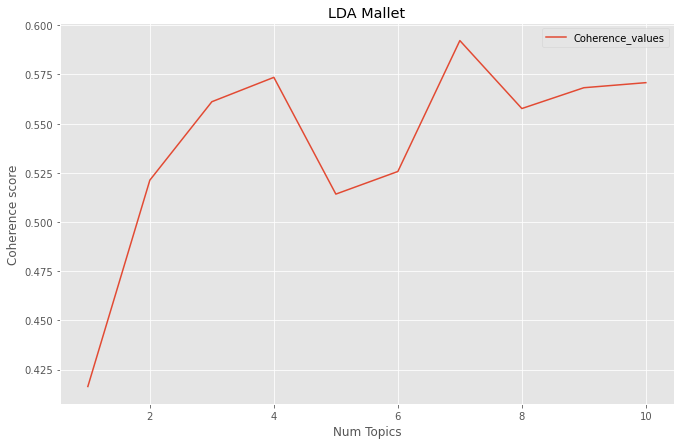

In [106]:
# model_list, coherence_values = compute_coherence_values(dictionary=trigram_id2word, corpus=trigram_corpus, texts=data_trigrams, start=start, limit=limit, step=step)

# Show graph

x = model_values_df['num_topics'].values.tolist()

plt.figure(figsize=(11,7))

plt.plot(x, coherence_values)

plt.title('LDA Mallet')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence_values"], loc='best')
plt.show()

The coherence score peaks at creating 7 topics before it stagnates. 

In [107]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4164
Num Topics = 2  has Coherence Value of 0.5213
Num Topics = 3  has Coherence Value of 0.5612
Num Topics = 4  has Coherence Value of 0.5736
Num Topics = 5  has Coherence Value of 0.5142
Num Topics = 6  has Coherence Value of 0.5257
Num Topics = 7  has Coherence Value of 0.5922
Num Topics = 8  has Coherence Value of 0.5577
Num Topics = 9  has Coherence Value of 0.5683
Num Topics = 10  has Coherence Value of 0.5709


I've chosen topic 7 as it has the highest coherence score, 0.5922.

## Exporting the optimal model to pickle file

In [108]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/amd_optimal_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(optimal_model, out_file)
out_file.close()

## Importing the optimal mallet model pickle file

In [110]:
# pkl_filename = "./models/amd_optimal_ldamallet_model.pkl"
# infile = open(pkl_filename,'rb')
# optimal_model = pickle.load(infile)
# infile.close()

In [111]:
# optimal_model

## Displaying topics for the optimal model (7 topics)

In [114]:
pprint(optimal_model.show_topics(formatted=False))

[(0,
  [('cpu', 0.031109781633263535),
   ('gpu', 0.027007392846459553),
   ('4k', 0.023930601256356567),
   ('rtx', 0.020682876800136748),
   ('1440p', 0.014999359001752062),
   ('power', 0.0136318960728174),
   ('higher', 0.01320456390752532),
   ('fps', 0.013033631041408486),
   ('review', 0.012990897824879279),
   ('memory', 0.01226443314388274)]),
 (1,
  [('3080', 0.06764206955046649),
   ('3070', 0.06255301102629347),
   ('6800', 0.059117896522476676),
   ('6800xt', 0.040161153519932144),
   ('vram', 0.027268871925360476),
   ('6900xt', 0.023960983884648006),
   ('benchmark', 0.023155216284987276),
   ('xt', 0.019889737065309585),
   ('2080ti', 0.017302798982188294),
   ('faster', 0.016200169635284138)]),
 (2,
  [('amd', 0.08324987481221832),
   ('nvidia', 0.060632615590051744),
   ('price', 0.05387247537973627),
   ('3090', 0.03964279752962777),
   ('card', 0.02303455182774161),
   ('gaming', 0.02199132031380404),
   ('end', 0.014521782674011016),
   ('gen', 0.013395092638958437

## Interpreting the 7 topics 

Topic 0
* Different resolutions such as 1440p and 4k and possibly the gpu' memory. 

Topic 1
* Different models of GPU

Topic 2
* Nvidia's pricing of 3090. (Possibly too expensive)

Topic 3
* Driver related issue and the gaming console and PCs.

Topic 4
* Stock availability during launch

Topic 5
* Point of time in purchase

Topic 6
* Different features provided by GPUs such as ray_tracing and dlss.

## Creating tags for the dominant topics

In [141]:
dominant_topic_to_tag = {0.0:'resolution', 1.0:'model', 2.0:'3090 pricing', 3.0: 'Driver/gaming console'
                        ,4.0: 'stock availability', 5.0: 'Purchase', 6.0: 'gpu feature'}
df_dominant_topic['Tag'] = df_dominant_topic['Dominant_Topic'].map(lambda x:dominant_topic_to_tag.get(x))
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document,Tag
0,0,2.0,0.1725,"amd, nvidia, price, 3090, card, gaming, end, g...","[sound, samsung_8nm, cheap]",3090 pricing
1,1,5.0,0.1796,"people, buy, good, point, time, bad, money, pr...","[ethic, mongol, invasion, tech]",Purchase
2,2,6.0,0.2052,"amd, dl, nvidia, game, ray_tracing, rt, featur...","[nvidia, software, ai, learning, big, selling,...",gpu feature
3,3,2.0,0.1910,"amd, nvidia, price, 3090, card, gaming, end, g...","[excited, amd, guy, compete, going, nvidia, br...",3090 pricing
4,4,2.0,0.1794,"amd, nvidia, price, 3090, card, gaming, end, g...","[think, nvidia, actualy, competing, new, conso...",3090 pricing
...,...,...,...,...,...,...
14521,14521,5.0,0.1950,"people, buy, good, point, time, bad, money, pr...","[dude, understand, example, confused, said, lo...",Purchase
14522,14522,4.0,0.1566,"card, wait, stock, launch, release, order, day...","[know, example, thought, looked]",stock availability
14523,14523,0.0,0.1779,"cpu, gpu, 4k, rtx, 1440p, power, higher, fps, ...","[probably, score, higher, english, proficiency...",resolution
14524,14524,6.0,0.1663,"amd, dl, nvidia, game, ray_tracing, rt, featur...","[prove, know, concept, cost, opportunity, effi...",gpu feature


# Finding the dominant topic in each sentence

I would like to investigate the dominant topics for the documents and see if it makes sense.

In [116]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for _, row in enumerate(ldamodel[corpus]): # ldamodel[corpus] --> Provides a list of the probability values of which topic a document belongs to
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # Sorts the probabilities of a document is descending order
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic (As it's sorted in descending order, the highest probability is the first topic which is index 0)
                wp = ldamodel.show_topic(topic_num) # Obtain the dominant topic for the document
                topic_keywords = ", ".join([word for word, prop in wp]) # Gets the topic keys words for the topic
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

Notes: The last model trained **must match** with the last optimal_file_doctopics text file. If not, there will be an error message.

In [117]:
# Retrain the model if you've have not done so
# optimal_num_topics = 6
# optimal_model = LdaMallet(mallet_path, corpus=trigram_corpus, num_topics=optimal_num_topics, id2word=trigram_id2word,
#                                                  prefix='optimal_', random_seed=42)

In [118]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=trigram_corpus, texts=data_trigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,2.0,0.1725,"amd, nvidia, price, 3090, card, gaming, end, g...","[sound, samsung_8nm, cheap]"
1,1,5.0,0.1796,"people, buy, good, point, time, bad, money, pr...","[ethic, mongol, invasion, tech]"
2,2,6.0,0.2052,"amd, dl, nvidia, game, ray_tracing, rt, featur...","[nvidia, software, ai, learning, big, selling,..."
3,3,2.0,0.1910,"amd, nvidia, price, 3090, card, gaming, end, g...","[excited, amd, guy, compete, going, nvidia, br..."
4,4,2.0,0.1794,"amd, nvidia, price, 3090, card, gaming, end, g...","[think, nvidia, actualy, competing, new, conso..."
5,5,2.0,0.2446,"amd, nvidia, price, 3090, card, gaming, end, g...","[reputable, leak, rdna2, say, 40, 50, faster, ..."
6,6,2.0,0.3180,"amd, nvidia, price, 3090, card, gaming, end, g...","[im, sure, amd, good, rdna, generation, rt, im..."
7,7,5.0,0.1585,"people, buy, good, point, time, bad, money, pr...","[b4, refresh, ampere, 7nm, throw, dirt, wound,..."
8,8,1.0,0.2026,"3080, 3070, 6800, 6800xt, vram, 6900xt, benchm...","[thread, deleted, aswell, post, r, p, amd, off..."
9,9,1.0,0.1582,"3080, 3070, 6800, 6800xt, vram, 6900xt, benchm...","[amd, going, need, pull, double, 5700xt, wish,..."


In [119]:
# Sort the dataframe in ascending order by the topic percentage contribution
df_dominant_topic_sorted = df_dominant_topic.sort_values('Topic_Perc_Contrib', ascending=False)
idx = np.random.randint(df_dominant_topic_sorted.shape[0])
# idx = 250
document = df_dominant_topic_sorted[['Document']].iloc[idx].values
dominant_topic = df_dominant_topic_sorted[['Dominant_Topic']].iloc[idx].values
dominant_keywords = df_dominant_topic_sorted[['Keywords']].iloc[idx].values

In [120]:
print(f'Dominant keywords: {dominant_keywords} \n\nDocument:{document}')

Dominant keywords: ['card, wait, stock, launch, release, order, day, month, gonna, hope'] 

Document:[list(['technology', '10', 'year', 'ago', 'year', 'ago', 'year', 'ago', 'relive', 'truly', 'recent', 'important', 'year', 'ago', 'lisa_su', 'fixated', 'cpu', 'department', 'gpu', 'department', 'needed', 'department', 'overhaul', 'tbh', 'amd', 'proved', 'today', 'company', 'year', 'ago', 'year', 'ago', '10', 'year', 'ago', 'amd', 'showed', 'optimistic', 'today', 'past', 'proved', 'optimistic', 'punishable', 'logic', 'amd', 'past', 'launch', 'big', 'disappointment', 'instead', 'probably', 'best', 'launch'])]


The document is relating to the price and performance of AMD against the Nividia's pascal and ampere's generation of GPUs as well as discussing about the Thermal Design Power (TDP) in which the GPUs generate heat and draw electricity as `100w` was seen in the document. 

In [121]:
print(f'Dominant keywords: {dominant_keywords} \n\n Document:{document}')

Dominant keywords: ['card, wait, stock, launch, release, order, day, month, gonna, hope'] 

 Document:[list(['technology', '10', 'year', 'ago', 'year', 'ago', 'year', 'ago', 'relive', 'truly', 'recent', 'important', 'year', 'ago', 'lisa_su', 'fixated', 'cpu', 'department', 'gpu', 'department', 'needed', 'department', 'overhaul', 'tbh', 'amd', 'proved', 'today', 'company', 'year', 'ago', 'year', 'ago', '10', 'year', 'ago', 'amd', 'showed', 'optimistic', 'today', 'past', 'proved', 'optimistic', 'punishable', 'logic', 'amd', 'past', 'launch', 'big', 'disappointment', 'instead', 'probably', 'best', 'launch'])]


In the above document, the dominant keywords reflect the document with purchasing a GPU. 

# Find the most representative document for each topic

In [122]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format the columns
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5020,"cpu, gpu, 4k, rtx, 1440p, power, higher, fps, ...","[going, 192, probably, huge, change, worst_cas..."
1,1.0,0.4080,"3080, 3070, 6800, 6800xt, vram, 6900xt, benchm...","[big, skews, argument, close, 6800, price, 680..."
2,2.0,0.4786,"amd, nvidia, price, 3090, card, gaming, end, g...","[theory, departure, titan, branding, simply, r..."
3,3.0,0.4717,"year, driver, game, console, issue, gpu, work,...","[nvidia, driver, closed, source, linux, fo, ta..."
4,4.0,0.5245,"card, wait, stock, launch, release, order, day...","[alright, called, couple, cc, location, 4038, ..."
5,5.0,0.6811,"people, buy, good, point, time, bad, money, pr...","[corrected, multiple, time, insinuating, decis..."
6,6.0,0.6226,"amd, dl, nvidia, game, ray_tracing, rt, featur...","[example, ray_tracing, insanely, computational..."


## Most representative document for Topic 0

In [123]:
# Create a helper function to display the most representative documents for a topic
def display_representative_document(topic_n, df):
    dominant_keywords = df['Keywords'].loc[topic_n]
    document_topic = " ".join(df['Representative Text'].loc[topic_n])
    
    print(f'*******Topic {topic_n}********\n\nDominant keywords: {dominant_keywords} \n\nDocument:{document_topic}')

In [124]:
display_representative_document(0, sent_topics_sorteddf_mallet)

*******Topic 0********

Dominant keywords: cpu, gpu, 4k, rtx, 1440p, power, higher, fps, review, memory 

Document:going 192 probably huge change worst_case ideal universe access happen cache prefetchers keeping flowing practice weird access happen stall loading occurs happens reduction bandwidth suddenly matter ton bulk read writes happen frame buffer need texture model 128mb give 4k hdr frame 50 ish mb rest left texture 4k non hdr frame 2x msaa 100mb wish review looked maybe anandtech frame buffer 96mb cache suddenly room prefetch texture need bandwidth go time fewer cu mean demand go somewhat playing 1440p instead suddenly non framebuffer size 96mb similar mean choose larger resolution lower texture lower resolution higher texture reduce cache thrashing 128mb 4k 256_bit 96mb 1440p 192 bit 64mb 1080p 128 bit seriously doubt week dedicated gpu die_size perfect apu amd known apple m1 doubt given affect current agreement likewise know intel xe 30 cu doable shown collaboration intel trad

## Most representative document for Topic 1

In [125]:
display_representative_document(1, sent_topics_sorteddf_mallet)

*******Topic 1********

Dominant keywords: 3080, 3070, 6800, 6800xt, vram, 6900xt, benchmark, xt, 2080ti, faster 

Document:big skews argument close 6800 price 6800xt 70 dollar seperates 15 percent price increase gap certainly higher bet 15 20 percent 3070 v 3080 40 percent price increase 3080 nearly make difference card especially 4k consider 3070 8gb vram 6800 enters weird 3070ti spot viable 4k vram likely realistic 10 15 percent lead 3070 80 usd cheaper higher end squeezing budget help feel 6800 priced 530 550 dollar sensible amd revenue higher end make_sense push user considering


## Most representative document for Topic 2

In [126]:
display_representative_document(2, sent_topics_sorteddf_mallet)

*******Topic 2********

Dominant keywords: amd, nvidia, price, 3090, card, gaming, end, gen, cost, market 

Document:theory departure titan branding simply running name tack word titan gtx titan released 2013 gtx titan black released february 2014 gtx titan z released march 2014 gtx titan x released 2015 titan x 2016 released 2016 titan xp released april 2017 titan v released december 2017 titan rtx released 2018 taking xx90 numbering allows settle simpler naming scheme generation come 4090 5090


## Most representative document for Topic 3

In [127]:
display_representative_document(3, sent_topics_sorteddf_mallet)

*******Topic 3********

Dominant keywords: year, driver, game, console, issue, gpu, work, good, time, pc 

Document:nvidia driver closed source linux fo tarnished proprietary driver nvidia proprietary driver interact linux kernel desktop environment way open_source driver end use nvidia proprietary control panel tweak thing nvidia proprietary driver support thing necessary wayland long time gallium best way play d3d9 game worked fo driver crash multi monitor scenario hate tv trying set nvidia optimus configuration absolute hell distros amd intel use dri_prime work question asked offloading nvidia gpu nightmare hack proprietary prime implementation stubborn asshole refuse join amd intel making good open driver integrate o literally way restrict development open_source driver digitally signed firmware ship proprietary driver allows card clock high level table scrap firmware hand fo driver development locked boot clock mean nouveau pristine compiler perform garbage clock gpu useful level 

## Most representative document for Topic 4

In [128]:
display_representative_document(4, sent_topics_sorteddf_mallet)

*******Topic 4********

Dominant keywords: card, wait, stock, launch, release, order, day, month, gonna, hope 

Document:alright called couple cc location 4038 hwy 7 unionville personal fav 6600 yonge st manager unionville sure 6800xt card tmr allow pre_order partner card preorders reference version priority taking pre_order reference card apparently come head office rep spoke manager centerpoint know tmr unlikely taking pre_order mixed message existing pre_order priority partner pre_order location belief reference card existing order need fulfill aib card absolutely word model going coming


## Most representative document for Topic 5

In [129]:
display_representative_document(5, sent_topics_sorteddf_mallet)

*******Topic 5********

Dominant keywords: people, buy, good, point, time, bad, money, product, reason, sell 

Document:corrected multiple time insinuating decision stem 700 msrp mentioned comment bud wrong disclosed reply comment original reply stated sounded bad idea original comment disclosed information original reply said sounded bad idea possible different conclusion different circumstance clarified simply said 6800xt obviously 6900xt expensive imply terrible_idea simply implied look worth trouble insinuate decision stem 700 msrp insinuated terrible_idea upset look r hardwareswap selling 3080s loss arguing entirely bad faith point cared paid 150 base 700 msrp place decision entirely stem 850 price point time repeat stop twisting single word fuck word twist care r hardwareswap rate 3080 aways talking price launch date new radeon card later imagined talking usual case_scenario reason sound calm f buddy completely blind think sell right 850 model stated comment learn read stop backt

## Most representative document for Topic 6

In [152]:
display_representative_document(6, sent_topics_sorteddf_mallet)

*******Topic 6********

Dominant keywords: amd, dl, nvidia, game, ray_tracing, rt, feature, support, raytracing, rtx 

Document:example ray_tracing insanely computationally expensive push higher higher resolution jumping 1080p 1440p 4k adding big load ray_tracing exacerbates essentially enabling ray_tracing half huge hit think agree exactly dl important negates halving ray_tracing guarantee devs away completely fake baking lighting cube map use rtx know long way away unfortunately yes computationally expensive far easier devs implement physic based work box hundred hour cube map hit generally getting ray_tracing effect certain area example ray_traced environmental lighting effect muzzle trade lighting option severe penalty yep absolute best implementation control far good cyberpunk implementation albeit bet extremely good given close partnership nvidia said implementation computational cost high best cast ray_pixel enormously far realistic rendering theoretically say need cast 500 ray_

# Topic distribution across documents

In [130]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num = pd.Series(sorted(df_topic_sents_keywords['Dominant_Topic'].unique()))
topic_keywords = sent_topics_sorteddf_mallet['Keywords']

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num, topic_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(6)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"cpu, gpu, 4k, rtx, 1440p, power, higher, fps, ...",2072,0.1426
1.0,1.0,"3080, 3070, 6800, 6800xt, vram, 6900xt, benchm...",2538,0.1747
2.0,2.0,"amd, nvidia, price, 3090, card, gaming, end, g...",1952,0.1344
3.0,3.0,"year, driver, game, console, issue, gpu, work,...",1851,0.1274
4.0,4.0,"card, wait, stock, launch, release, order, day...",2623,0.1806
5.0,5.0,"people, buy, good, point, time, bad, money, pr...",1648,0.1135


In [131]:
# Sort the Percentage of documents in descending order
df_dominant_topics.sort_values(by='Perc_Documents', ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
4.0,4.0,"card, wait, stock, launch, release, order, day...",2623,0.1806
1.0,1.0,"3080, 3070, 6800, 6800xt, vram, 6900xt, benchm...",2538,0.1747
0.0,0.0,"cpu, gpu, 4k, rtx, 1440p, power, higher, fps, ...",2072,0.1426
2.0,2.0,"amd, nvidia, price, 3090, card, gaming, end, g...",1952,0.1344
3.0,3.0,"year, driver, game, console, issue, gpu, work,...",1851,0.1274
6.0,6.0,"amd, dl, nvidia, game, ray_tracing, rt, featur...",1842,0.1268
5.0,5.0,"people, buy, good, point, time, bad, money, pr...",1648,0.1135


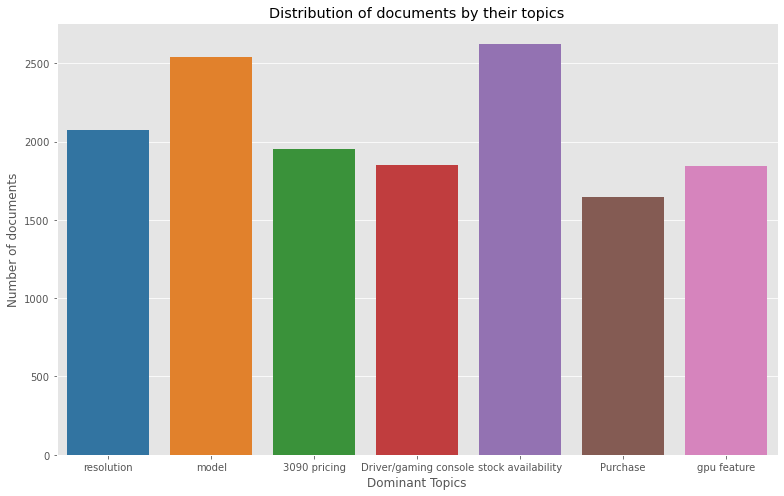

In [151]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

plt.figure(figsize=(11,7))
sns.barplot(x='Dominant_Topic', y='Num_Documents',data=df_dominant_topics, palette=cols)

plt.title('Distribution of documents by their topics')
plt.xticks(np.arange(len(dominant_topic_to_tag.values())), list(dominant_topic_to_tag.values()), fontsize=10)
plt.xlabel('Dominant Topics')
plt.ylabel('Number of documents')
plt.tight_layout()

The topic of Stock availability has the most documents with over 2500 documents assigned to it. It seems that consumers are not able to purchase GPUs during the launch given that there are bots which purchase the GPUs almost instantly the moment the GPUs are up for sale. The different types of GPU models has the second most assigned topic, with consumers comparing against the price and performance of the gpu manufacturers. The topic of purchase is the least assigned, which means these consumers have enough purchasing power to buy these GPUs.

# Frequency Distribution of Word Counts in Documents by dominant topic

C:\Users\Trogg\anaconda3\envs\mlbook2\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Trogg\anaconda3\envs\mlbook2\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


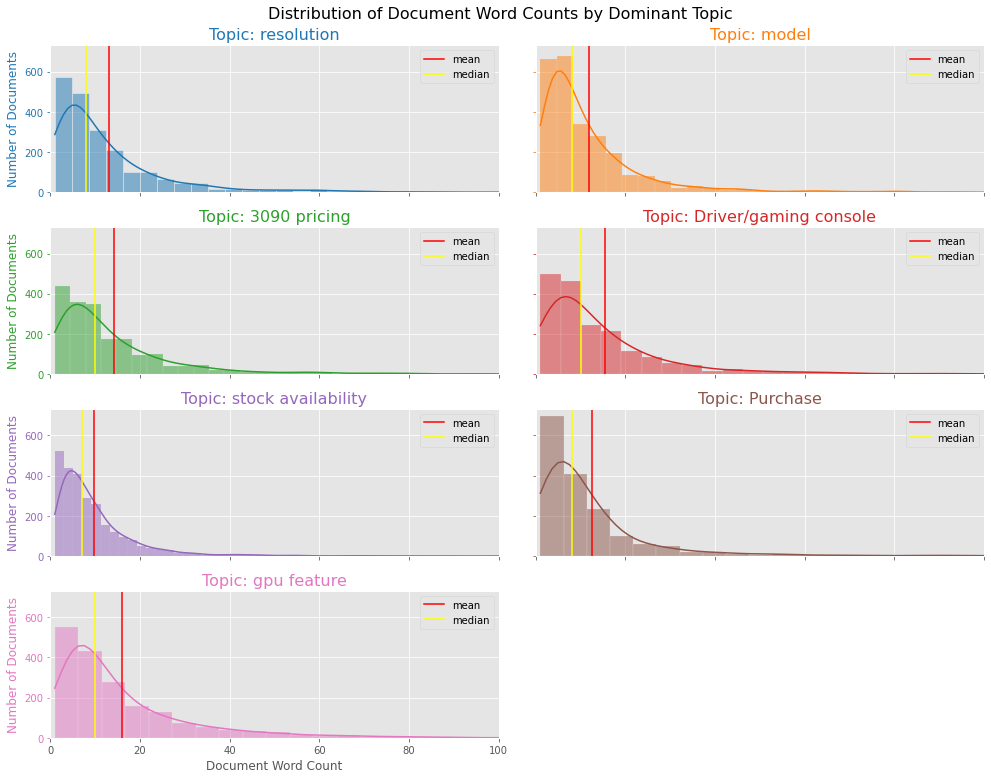

In [158]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(4,2, figsize=(14,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i]
    doc_lens = df_dominant_topic_sub.Document.map(lambda token: len(token)).tolist()
    #ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.histplot(doc_lens, bins=50, color=cols[i], kde=True, ax=ax) # ax.twinx()
    # Mean
    ax.axvline(np.mean(doc_lens), color='red', label='mean')
    # Median
    ax.axvline(np.median(doc_lens), color='yellow', label='median')
    ax.legend()
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+ str(dominant_topic_to_tag.get(i)), fontdict=dict(size=16, color=cols[i]))

# fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,375,9))
plt.xlim(0,100)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.tight_layout()
axes.flat[-1].set_visible(False)
plt.show()

All of the distributions shows a right tailed skewed graph in which the mean and median are quite close.

# Word Clouds of Top N Keywords in Each Topic

In [134]:
stop_words = set(STOPWORDS).union(stopwords.words("english")) # Combines gensim stopwords and nltk's stopwords
stop_words = stop_words.union(['http', 'www', 'youtube' 'get', 'like', '1', '2', '3', '5', 'got'])

IndexError: list index out of range

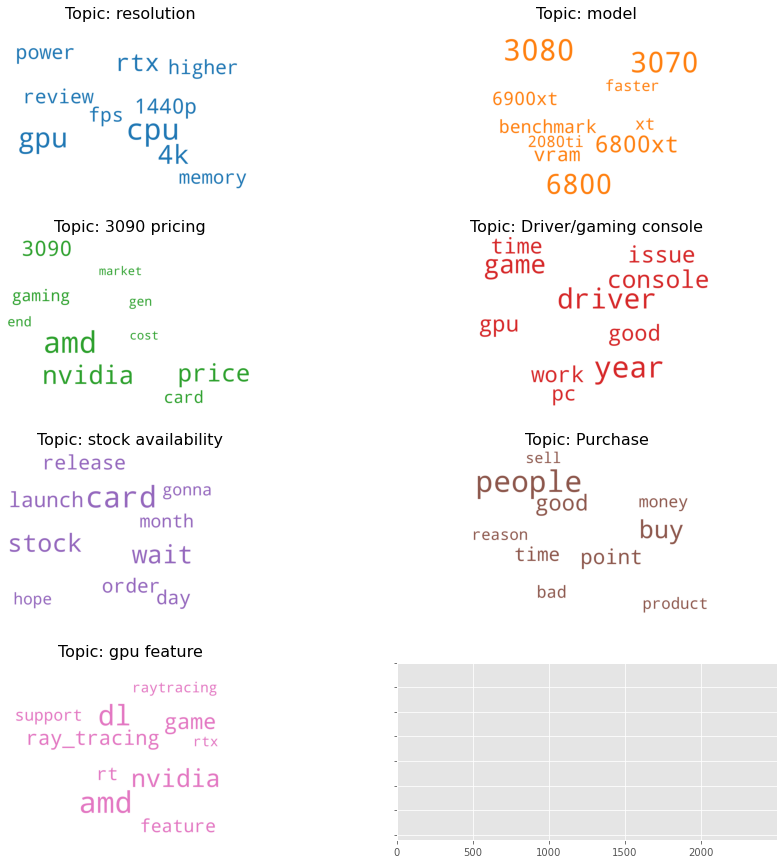

In [165]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic: ' + str(dominant_topic_to_tag.get(i)), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

In [136]:
data_flat = [word for word_lst in data_trigrams for word in word_lst] # Creates a list of words 
counter = Counter(data_flat) # Counts the frequency of the tokens and stores in a dictionary
counter

Counter({'sound': 124,
         'samsung_8nm': 25,
         'cheap': 94,
         'ethic': 3,
         'mongol': 14,
         'invasion': 3,
         'tech': 191,
         'nvidia': 2584,
         'software': 231,
         'ai': 102,
         'learning': 8,
         'big': 323,
         'selling': 110,
         'point': 502,
         'excited': 57,
         'amd': 3648,
         'guy': 175,
         'compete': 256,
         'going': 894,
         'brand_loyalty_sucker': 7,
         'think': 1149,
         'actualy': 1,
         'competing': 69,
         'new': 747,
         'console': 505,
         'price': 1672,
         '499': 90,
         '2080ti': 410,
         'dumping': 1,
         'reputable': 5,
         'leak': 63,
         'rdna2': 190,
         'say': 95,
         '40': 49,
         '50': 373,
         'faster': 382,
         'couple': 99,
         'rumored': 23,
         'focus': 29,
         'power': 319,
         'efficiency': 63,
         'advantage': 119,
         'tsmc

In [137]:
out = [[word, i , weight, counter[word]] for i, topic in topics for word, weight in topic]
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.head()

,word,topic_id,importance,word_count
0,cpu,0,0.031110,728
1,gpu,0,0.027007,1063
2,4k,0,0.023931,567
3,rtx,0,0.020683,827
4,1440p,0,0.014999,351


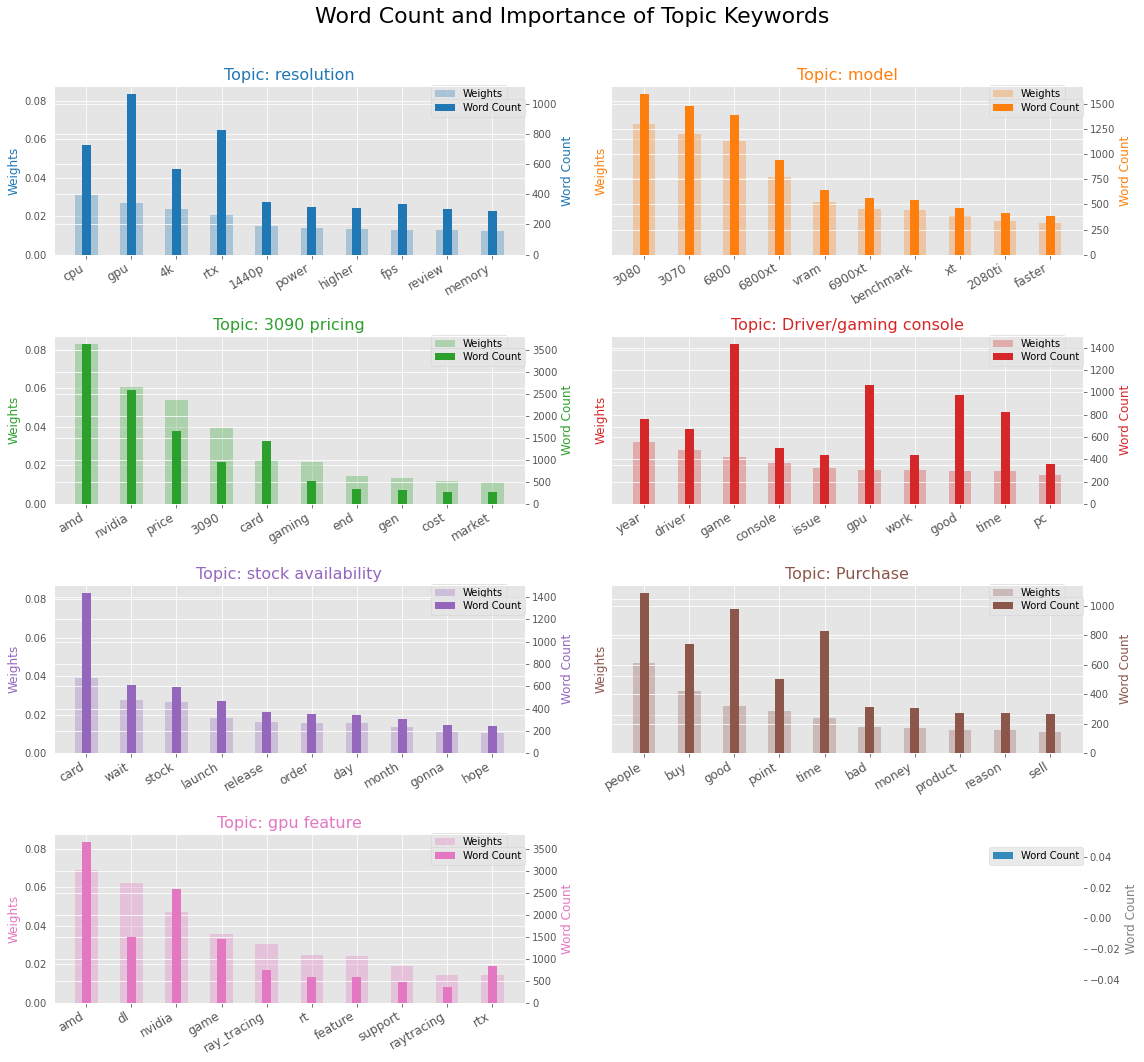

In [171]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,14), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Weights')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Word Count')
    ax.set_ylabel('Weights', color=cols[i])
    ax_twin.set_ylabel('Word Count', color=cols[i])
    # Sets the ylimits for the axes
    #ax_twin.set_ylim(0, 0.030)
    #ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(dominant_topic_to_tag.get(i)), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'].tolist(), rotation=30, horizontalalignment= 'right', fontsize=12)
    ax_twin.legend(loc=[0.80,0.82])
    ax.legend(loc=[0.80,0.90])
    
axes.flat[-1].set_visible(False)
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Intrepreting the topic word frequency and their weights

Topic: Resolution
* GPU's memory plays a more important role than the CPU as the higher the resolution, the more video ram it consumes
* Resolution: Surprisingly, 4k resolution has a higher frequency and weight compared to 1440p resolution, which is not so main stream yet. 1440p resolution is reaching mainstream crowd.

Topic: Model
* Nvidia's RTX 3080 and RTX 3070 have a higher word count and weights compared to AMD's 6800 and 6800xt models
* I've read some of the comments and it seems the RTX 3070 is faster than the RTX 2080ti, which is the previous generation for almost a third of the price

Topic: 3090 pricing
* Most of the topic keyword's topic weights exceed that of their word frequency, which highlights the the keyword's importance 
* Apparently the 3090 is found the expensive among the consumers

Topic: Driver/Gaming console
* Driver related issue

Topic: Stock availability
* Consumers are hoping that there is stock available for the purchase of the GPUs during the launch of the GPUs

Topic: Purchase
* Topic keyword buy has a higher word count and weightage compared to sell which seem to suggest that these consumers have strong purchasing power, or the GPUs are fairly priced.
* People purchase product at different points of time

Topic: gpu feature
* Ray tracing and dlss (Deep learning super sampling) seems to be the most talked features among the consumers

# t-SNE Clustering Chart

In [139]:
# Get topic weights
topic_weights = []

for row_lst in optimal_model[trigram_corpus]:
    lst = []
    for topic_id, topic_perc in row_lst:
        lst.append(topic_perc)
    topic_weights.append(lst)
    

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=30, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
lgd_label = np.array(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])

source = ColumnDataSource(dict(
    x=tsne_lda[:,0],
    y=tsne_lda[:,1],
    color=mycolors[topic_num],
))

plot.scatter(x='x', y='y', color='color', source=source)
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.000s...
[t-SNE] Computed neighbors for 99 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 0.224641
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.317959
[t-SNE] KL divergence after 1000 iterations: 0.047919


Loading BokehJS ...

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised non-linear learning technique used for data exploration and visualizing higher dimensional data. It gives a sense of how the data is arranged in a high dimensional-space. As t-SNE preserves small pairwise compared to Principal Component Analysis (PCA), we can see that the Topics are clearly distinguishable from one another. 

# pyLDAVis

In [140]:
# Visualize the topics for the trigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'amd_' + 'trigram_' +'mallet_ldavis_prepared_'+str(num_topics))

optimal_model_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
trigram_mallet_vis = pyLDAvis.gensim.prepare(optimal_model_lda, trigram_corpus, trigram_id2word)

# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(trigram_mallet_vis, os.getcwd()+ '\\visualization\\' + 'amd_' + 'trigram_' + 'mallet_ldavis_prepared_'+ str(num_topics) +'.html')
trigram_mallet_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.196832 -0.219132       1        1  14.621015
6      0.238666 -0.214920       2        1  14.560430
0     -0.099203 -0.062773       3        1  14.478889
2      0.289550 -0.031940       4        1  14.452602
5     -0.260710 -0.002794       5        1  14.323399
1      0.072064  0.290629       6        1  14.096885
4     -0.043536  0.240930       7        1  13.466780, topic_info=       Term         Freq        Total Category  logprob  loglift
14      amd  4161.000000  4161.000000  Default  30.0000  30.0000
10   nvidia  2947.000000  2947.000000  Default  29.0000  29.0000
98     3080  1799.000000  1799.000000  Default  28.0000  28.0000
384      dl  1705.000000  1705.000000  Default  27.0000  27.0000
97     3070  1663.000000  1663.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
260   model   179.452206   187.348261   Topic7  -4.9530   1.9619
150  launch   459.988250   530.034959   Topic7  -4.0117   1.8632
275    card   991.530227  1631.116623   Topic7  -3.2436   1.5072
90     edit   182.859526   206.547691   Topic7  -4.9342   1.8831
838   guess   162.415604   331.151201   Topic7  -5.0527   1.2925

[513 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
415       2  1.000138     0
6713      7  0.968503    02
818       6  0.999451    10
883       4  1.001621  1000
8413      6  0.886519  1079
...     ...       ...   ...
5693      3  0.856577  z390
377       3  0.973535   zen
377       5  0.026599   zen
8405      6  0.886519    äh
8512      6  0.886519  ｒａｇｅ

[554 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 1, 3, 6, 2, 5])

The bubbles are spread further apart compared to the LDA's pyLDAvis with the exception of topic 7 and 6. This shows that the topics are distinguishable from one another and it could be the result of a higher number of topics. Also, it seems that the bubbles are of similar sizes which means that the documents are evenly distributed across the topics.